# Finding features of our PSD

In [72]:
# loading the packages
import numpy as np
# import mne
from tqdm import tqdm
# from tqdm import tqdm
import skfda
import pandas as pd
# import os
# import matplotlib.pyplot as plt
# from skfda.exploratory.visualization import Boxplot
from skfda.inference.anova import oneway_anova
import scipy
import os

import matplotlib.pyplot as plt


In [73]:
# selezionare banda di frequenza
banda=str(1)

# selzione del canale che stiamo studiando
i = 1
canale = str(i)

In [74]:
home_path = os.path.abspath(os.getcwd())
home_path

'c:\\Users\\erica\\OneDrive\\Documenti\\Uni_nuovo\\Necst\\NL2project\\FDAxEEG\\Dataset'

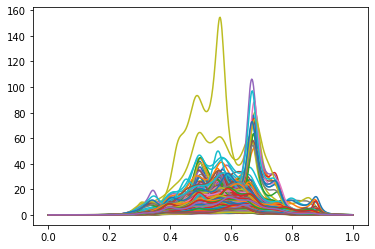

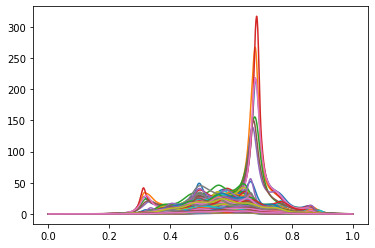

In [75]:
# loading the data of ADHD
filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+canale+"_p"+banda
mat = scipy.io.loadmat(filename_adhd)
PSD_ADHD=mat['avg']
df_Channel=pd.DataFrame(data=PSD_ADHD)
Channel=df_Channel.to_numpy(dtype=None, copy=False)
Channel = np.nan_to_num(Channel)
ADHD=skfda.FDataGrid(data_matrix=Channel)
ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

# loading the data of control
filename_control = home_path+"\Control_Matrici_medie\zona"+canale+"_p"+banda
mat = scipy.io.loadmat(filename_control)
PSD_control=mat['avg']
df_Channel=pd.DataFrame(data=PSD_control)
Channel=df_Channel.to_numpy(dtype=None, copy=False)
Channel = np.nan_to_num(Channel)
Channel = Channel[0:427,:]
Control=skfda.FDataGrid(data_matrix=Channel)
Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

plot_adhd = ADHD.plot()
plot_control = Control.plot()

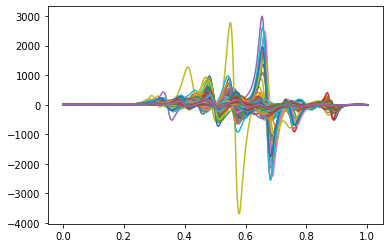

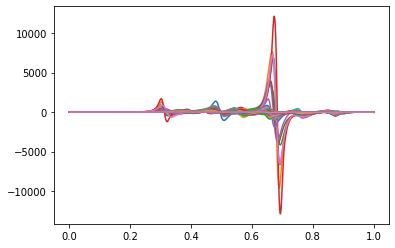

In [76]:
# computing the derivatives of the curves
ADHD_der=ADHD.derivative()
Control_der=Control.derivative()

plot_adhd_der = ADHD_der.plot()
plot_control_der = Control_der.plot()
    

### Computing the intergral of the absolute value of the first derivative
$$ I = \int \|f'(t)\| dt $$

Median: 24.187641869531944
Mean: 33.97126106604104
Starndard deviation: 33.59599897683493


{'whiskers': [<matplotlib.lines.Line2D at 0x1be2de81850>,
 'caps': [<matplotlib.lines.Line2D at 0x1be2de81df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1be2de81580>],
 'medians': [<matplotlib.lines.Line2D at 0x1be2de873d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1be2de876a0>],
 'means': []}

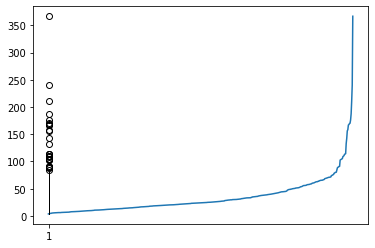

In [77]:
# integral of the derivative of the adhd group
ADHD_der_abs = ADHD_der
ADHD_der_abs.data_matrix=np.abs(ADHD_der.data_matrix)

n_adhd = ADHD_der_abs.data_matrix.shape[0]

int_adhd = np.empty(n_adhd)
for i in range(n_adhd):
    int_adhd[i]=scipy.integrate.simpson(np.transpose(ADHD_der_abs.data_matrix[i]), ADHD_der_abs.grid_points[0])

plt.plot(np.sort(int_adhd))
print("Median: "+str(np.median(int_adhd)))
print("Mean: "+str(np.mean(int_adhd)))
print("Starndard deviation: "+str(np.std(int_adhd)))

plt.boxplot(int_adhd)

Median: 24.202760240853724
Mean: 37.34111752216298
Starndard deviation: 58.177333684941516


{'whiskers': [<matplotlib.lines.Line2D at 0x1be1d82a5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1be1d82ab50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1be1d82a310>],
 'medians': [<matplotlib.lines.Line2D at 0x1be1d7c1130>],
 'fliers': [<matplotlib.lines.Line2D at 0x1be1d7c1400>],
 'means': []}

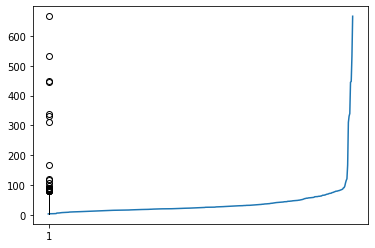

In [78]:
# integral of the derivative of the control group
Control_der_abs = Control_der
Control_der_abs.data_matrix=np.abs(Control_der.data_matrix)

n_cont = Control_der_abs.data_matrix.shape[0]

int_cont = np.empty(n_cont)
for i in range(n_cont):
    int_cont[i]=scipy.integrate.simpson(np.transpose(Control_der_abs.data_matrix[i]), Control_der_abs.grid_points[0])

plt.plot(np.sort(int_cont))
print("Median: "+str(np.median(int_cont)))
print("Mean: "+str(np.mean(int_cont)))
print("Starndard deviation: "+str(np.std(int_cont)))

plt.boxplot(int_cont)


ShapiroResult(statistic=0.6805058717727661, pvalue=5.0334216712379635e-31)
ShapiroResult(statistic=0.3761921525001526, pvalue=1.0021547800775977e-35)
ShapiroResult(statistic=0.993999183177948, pvalue=0.027193835005164146)
ShapiroResult(statistic=0.9679392576217651, pvalue=4.72033576670583e-08)


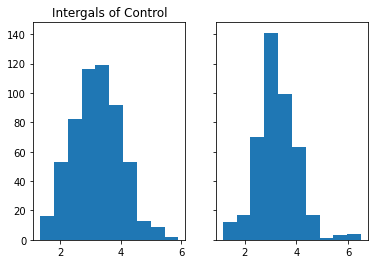

In [79]:
int_adhd_log = np.log(int_adhd)
int_cont_log = np.log(int_cont)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(int_adhd_log)
ax1.set_title('Intergals of ADHD')
ax2.hist(int_cont_log)
ax1.set_title('Intergals of Control')


print(scipy.stats.shapiro(int_adhd))
print(scipy.stats.shapiro(int_cont))

print(scipy.stats.shapiro(int_adhd_log))
print(scipy.stats.shapiro(int_cont_log))

### Anova on the integrals

In [54]:
aov = scipy.stats.f_oneway(int_adhd,int_cont, axis=0)
print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

ANOVA results: 
F statistics: 	0.6074196659461317
p_value: 	0.4359491730518318


### Same study extended to all the zones and frequential bands

In [55]:
# funzione per calcolare integrali delle derivate e fare anova tra i due gruppi

def AnovaIntDer(canale, banda, home_path):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Channel = Channel[0:427,:]
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # compute the derivatives of the functions
    ADHD_der=ADHD.derivative()
    Control_der=Control.derivative()

    # integral of the derivative of the adhd group
    ADHD_der_abs = ADHD_der
    ADHD_der_abs.data_matrix=np.abs(ADHD_der.data_matrix)

    n_adhd = ADHD_der_abs.data_matrix.shape[0]

    int_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        int_adhd[i]=scipy.integrate.simpson(np.transpose(ADHD_der_abs.data_matrix[i]), ADHD_der_abs.grid_points[0])
        
    # print("ADHD:")
    # print("Median: "+str(np.median(int_adhd)))
    # print("Mean: "+str(np.mean(int_adhd)))
    # print("Starndard deviation: "+str(np.std(int_adhd)))

    # integral of the derivative of the control group
    Control_der_abs = Control_der
    Control_der_abs.data_matrix=np.abs(Control_der.data_matrix)

    n_cont = Control_der_abs.data_matrix.shape[0]

    int_cont = np.empty(n_cont)
    for i in range(n_cont):
        int_cont[i]=scipy.integrate.simpson(np.transpose(Control_der_abs.data_matrix[i]), Control_der_abs.grid_points[0])


    int_adhd = np.log(int_adhd)
    int_cont = np.log(int_cont)

    # print("Control:")
    # print("Median: "+str(np.median(int_cont)))
    # print("Mean: "+str(np.mean(int_cont)))
    # print("Starndard deviation: "+str(np.std(int_cont)))

    # ANOVA

    aov = scipy.stats.f_oneway(int_adhd,int_cont, axis=0)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    return aov.pvalue


In [56]:
p_val = np.empty((7,5))
p_val.shape

(7, 5)

In [57]:
for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaIntDer(canale, banda, home_path)   
    

In [58]:
print(pd.DataFrame(p_val))

              0             1             2             3         4
0  4.359492e-01  6.851452e-01  1.636452e-01  7.706036e-01  0.497288
1  1.517400e-08  2.110444e-09  1.404190e-07  4.723747e-10  0.000024
2  1.186823e-02  6.188488e-03  1.599932e-03  9.801597e-05  0.000526
3  6.093361e-01  1.215611e-01  1.009231e-01  1.862047e-01  0.808813
4  8.610577e-06  6.988937e-07  1.881826e-04  2.825047e-01  0.577482
5  1.000579e-03  4.776386e-04  1.466410e-03  6.150912e-04  0.016539
6  1.648131e-03  4.288962e-03  1.824787e-01  6.498089e-02  0.299857


## $L^2$ norm study

In [59]:
# funzione per calcolare norma L2 e fare anova tra i due gruppi

def AnovaNormLp(canale, banda, home_path, order=2):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)   
    Channel = Channel[0:427,:]
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # L2 norm of ADHD group
    n_adhd = ADHD.data_matrix.shape[0]

    norm_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        norm_adhd[i]=np.linalg.norm(ADHD.data_matrix[i], ord = order)

    # L2 norm of control group
    n_cont = Control.data_matrix.shape[0]

    norm_cont = np.empty(n_cont)
    for i in range(n_cont):
        norm_cont[i]=np.linalg.norm(Control.data_matrix[i], ord = order)

    norm_adhd = np.log(norm_adhd)
    norm_cont = np.log(norm_cont)

    # ANOVA

    aov = scipy.stats.f_oneway(norm_adhd,norm_cont, axis=0)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    return aov.pvalue


In [60]:
p_val_norm = np.empty((7,5))

for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaNormLp(canale, banda, home_path)

print(pd.DataFrame(p_val))

              0             1             2             3         4
0  8.338061e-01  8.230985e-01  2.552639e-01  7.441899e-01  0.548730
1  6.676076e-11  3.334550e-10  4.578513e-08  1.735718e-10  0.000015
2  2.825086e-04  2.626153e-04  9.039790e-04  1.333159e-04  0.000117
3  6.525131e-01  2.349668e-01  1.058770e-01  2.088113e-01  0.419458
4  3.972706e-06  2.245840e-06  2.624779e-04  2.920320e-01  0.134996
5  1.436048e-05  6.396778e-05  1.119279e-03  6.021545e-04  0.009459
6  1.749349e-04  1.539821e-03  1.436958e-01  5.045013e-02  0.134435
